<a href="https://colab.research.google.com/github/AbyssGazer-Oliver/Machine-Learning/blob/main/lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
pip install flickrapi

     |████████████████████████████████| 54 kB 2.2 MB/s 


In [ ]:
import flickrapi
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import requests
from io import BytesIO
%matplotlib inline

In [ ]:
api_key = u'49286b0b6f3b715fca25a3ebc2603504'
api_secret = u'0cd8076077dd2ded'
flickr = flickrapi.FlickrAPI(api_key, api_secret)

In [ ]:
car_keyword = 'car'
bicycle_keyword = 'bicycle'
car_photos = flickr.walk(text=car_keyword, tag_mode='all',
                           tags=car_keyword,extras='url_c',\
                           sort='relevance',per_page=100)
bicycle_photos=flickr.walk(text=bicycle_keyword, tag_mode='all',
                           tags=bicycle_keyword,extras='url_c',\
                           sort='relevance',per_page=100)

In [ ]:
def create_folder(dir_name):
  import os
  dir_exists = os.path.isdir(dir_name)
  if not dir_exists:
    os.mkdir(dir_name)
    print("Making directory %s" % dir_name)
  else:
    print("Will store images in directory %s" % dir_name)
create_folder('train')
create_folder('test')
create_folder('train/car')
create_folder('train/bicycle')
create_folder('test/car')
create_folder('test/bicycle')


Making directory train
Making directory test
Making directory train/car
Making directory train/bicycle
Making directory test/car
Making directory test/bicycle


In [ ]:
import warnings
def download_photo(photos,nimage,dir_name,keyword):
  i = 0
  nrow = 224
  ncol = 224
  for photo in photos:
    url=photo.get('url_c')
    if not (url is None):
      
      # Create a file from the URL
      # This may only work in Python3
      response = requests.get(url)
      file = BytesIO(response.content)

      # Read image from file
      im = skimage.io.imread(file)

      # Resize images
      im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant')

      # Convert to uint8, suppress the warning about the precision loss
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im2 = skimage.img_as_ubyte(im1)

      # Save the image
      local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format(dir_name,keyword, i)
      skimage.io.imsave(local_name, im2)

      i = i + 1
    if (i >= nimage):
      break

In [ ]:
download_photo(car_photos, 1000,'train/car','car')
download_photo(bicycle_photos, 1000,'train/bicycle','bicycle')
download_photo(car_photos, 300,'test/car','car')
download_photo(bicycle_photos, 300,'test/bicycle','bicycle')

In [ ]:
# TODO 1:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6665656004298808504
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15498424970509627003
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# TODO 2:
import tensorflow.keras.backend as K
K.clear_session()

In [ ]:
# TODO 3:  Set to smaller values if you are using a CPU.  
# Otherwise, do not change this code.
nrow = 150
ncol = 150

In [ ]:
# TODO 4:  Load the VGG16 network
pre_trained = 'vgg16'
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
# input_shape = ...
# base_model = applications.VGG16(weights='imagenet', ...)
from tensorflow.keras.applications.vgg16 import decode_predictions,preprocess_input
base_model =VGG16(include_top=False,input_shape=(nrow,ncol,3),weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Create a new model
model = Sequential()
# TODO 5: Loop over base_model.layers and add each layer to model
for layer in base_model.layers:
  model.add(layer)

In [ ]:
# TODO 6
for layer in model.layers:
  layer.trainable=False

In [ ]:
# TODO 7
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# TODO 8
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

In [ ]:
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
# TODO 9
test_data_dir = './test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [ ]:
# Display the image
def disp_image(im,pos,title):
  plt.subplot(1,8,pos)
  plt.title('%d' % title)
  if (len(im.shape) == 2):
    # Gray scale image
    plt.imshow(im, cmap='gray')
  else:
  # Color image.
    im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
    im1 = im1.astype(np.uint8)
    plt.imshow(im1)
  # Remove axis ticks
  plt.xticks([])
  plt.yticks([])


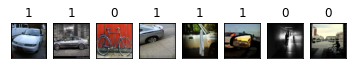

In [ ]:
# TODO 10
mini_batch_x,mini_bach_y=train_generator.next()
for i in range(8):
  disp_image(mini_batch_x[i],i+1,mini_bach_y[i])

In [ ]:
# TODO 11
opt=optimizers.Adam(learning_rate=1e-3, decay=1e-4)
hist=model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
# TODO 12
steps_per_epoch = train_generator.n//batch_size
validation_steps = test_generator.n//batch_size

In [ ]:
nepochs = 5  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
62/62 [==============================] - 36s 365ms/step - loss: 0.2522 - accuracy: 0.9070 - val_loss: 0.1094 - val_accuracy: 0.9618
Epoch 2/5
62/62 [==============================] - 21s 341ms/step - loss: 0.0961 - accuracy: 0.9629 - val_loss: 0.0900 - val_accuracy: 0.9635
Epoch 3/5
62/62 [==============================] - 21s 340ms/step - loss: 0.0797 - accuracy: 0.9710 - val_loss: 0.0758 - val_accuracy: 0.9792
Epoch 4/5
62/62 [==============================] - 21s 340ms/step - loss: 0.0535 - accuracy: 0.9802 - val_loss: 0.0767 - val_accuracy: 0.9774
Epoch 5/5
62/62 [==============================] - 21s 341ms/step - loss: 0.0495 - accuracy: 0.9827 - val_loss: 0.0906 - val_accuracy: 0.9740


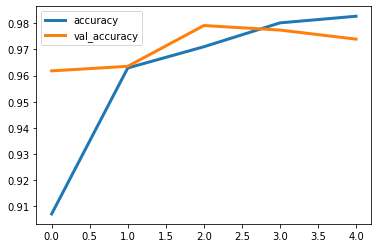

In [ ]:
# Plot the training accuracy and validation accuracy curves on the same figure.

# TODO 13
print(hist)
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
plt.plot(acc,'-',linewidth=3)
plt.plot(val_acc,'-',linewidth=3)
plt.legend(['accuracy','val_accuracy'])

(1, 150, 150, 3)


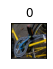

In [ ]:
# TODO 14
Xts,yts=test_generator.next()
y_hat=model.predict(Xts)
bool_err=(np.abs(y_hat - yts[:,None])>0.1).flatten()
err_pics = Xts[bool_err]
err_prediction = y_hat[bool_err]
print(err_pics.shape)
for i in range(err_pics.shape[0]):
  disp_image(err_pics[i],i+1,err_prediction[i])